In [2]:
import numpy as np
import pandas as pd
import pickle
from rdkit import Chem
import matplotlib.pyplot as plt

import sys
from pathlib import Path
root_directory = Path('__file__').parent.parent.resolve()
print('root_directory: ', root_directory)
project_directory = root_directory.parent
print('project_directory: ', project_directory)

sfscore_path = project_directory/'sfscore'
sys.path.append(str(sfscore_path))
print(sys.path)

from sfscore import SFScore
sfscore_model = SFScore()
sfscore_model.load()


root_directory:  /home/xuan/GitLab/synthetic-field-score/evalueate_score
project_directory:  /home/xuan/GitLab/synthetic-field-score
['/home/xuan/GitLab/synthetic-field-score/evalueate_score', '/home/xuan/miniconda3/envs/sfscore_tools/lib/python36.zip', '/home/xuan/miniconda3/envs/sfscore_tools/lib/python3.6', '/home/xuan/miniconda3/envs/sfscore_tools/lib/python3.6/lib-dynload', '', '/home/xuan/miniconda3/envs/sfscore_tools/lib/python3.6/site-packages', '/home/xuan/GitLab/biocatalysis-model', '/home/xuan/miniconda3/envs/sfscore_tools/lib/python3.6/site-packages/IPython/extensions', '/home/xuan/.ipython', '/home/xuan/GitLab/synthetic-field-score/sfscore']
Loading model /home/xuan/GitLab/synthetic-field-score/process_reaction_database/saved_model/ecfp4_4096_3_layer_epoch10.pt


In [9]:
def standardize_smiles_list (smi_ls):
    # Ref: https://github.com/itai-levin/hybmind/blob/main/analyze_templates/Notebooks/compare_model_outputs.ipynb
    std_ls = []
    for smi in smi_ls:
        mol = Chem.MolFromSmiles(smi)
        for atm in mol.GetAtoms():
            atm.SetAtomMapNum(0)
        std_ls.append(Chem.MolToSmiles(mol))
    return std_ls

def draw_sfscore_difference_distribution(score_list_1, title):
    a= score_list_1[:,0] - score_list_1[:,1]

    plt.hist(a, color = "steelblue", label = "in-vivo", bins=140,alpha = 0.7)

    #plt.ylim((0,1400))

    plt.ylabel('Number of molecules')
    plt.xlabel('S_Chem - S_Enzy')

    plt.show()

def get_diff_margin_distribution(score_list,margin_list=[0.05,0.1,0.15,0.2,0.25],title=None):
    a= score_list[:,0]
    b= score_list[:,1]
    sfscore_diff = a - b
    for margin in margin_list:
        chem_search_idx = [x > margin for x in sfscore_diff]
        enzy_search_idx = [x < -margin for x in sfscore_diff]
        # overlap_search_idx = np.multiply(enzy_search_idx, chem_search_idx)
        overlap_search_idx = [x >= -margin and x <= margin for x in sfscore_diff]
        chem_search_precent = sum(chem_search_idx)/len(sfscore_diff)
        enzy_search_precent = sum(enzy_search_idx)/len(sfscore_diff)
        overlap_search_precent = sum(overlap_search_idx)/len(sfscore_diff)
        print(f'margin: {margin}, chem_search_precent: {chem_search_precent:.4%}, enzy_search_precent: {enzy_search_precent:.4%}, overlap_search_precent: {overlap_search_precent:.4%}')
    

# Process ZINC(in-vitro) database

In [4]:
np.random.seed(42)
in_vitro = pd.read_csv('../data/in-vitro/in-vitro.csv')
rand_inds = np.random.choice(len(in_vitro), 12000)
in_vitro = in_vitro.loc[rand_inds, :]
in_vitro_subset = standardize_smiles_list(in_vitro['smiles'])

In [5]:
try:
    in_vitro_in_train = np.load('../data/in-vitro/in_vitro_in_train.npy')
    in_vitro_not_in_train_idxs = [x not in in_vitro_in_train for x in in_vitro_subset]
    print ('loaded saved file')
except:
    with open("../process_reaction_database/data/bio_products_uni.pkl","rb") as f:
        bio_products_uni = pickle.load(f)
    with open("../process_reaction_database/data/chem_products_uni.pkl","rb") as f:
        chem_products_uni = pickle.load(f)
    sfscore_subset = standardize_smiles_list(bio_products_uni + chem_products_uni)
    
    in_vitro_in_train = set(sfscore_subset).intersection(in_vitro_subset)
    in_vitro_not_in_train_idxs = [x not in in_vitro_in_train for x in in_vitro_subset]
    np.save('../data/in-vitro/in_vitro_in_train.npy', np.array(list(in_vitro_in_train)))
print (sum(in_vitro_not_in_train_idxs))

loaded saved file
11003


In [6]:
try:
    in_vitro_sfscore = np.load('../data/in-vitro/in_vitro_sfscore.npy')
except:
    in_vitro_sfscore = sfscore_model.score_from_smi_many(in_vitro_subset)
    np.save('../data/in-vitro/in_vitro_sfscore', in_vitro_sfscore)
    np.savetxt("../data/in-vitro/in_vitro_sfscore.csv", in_vitro_sfscore[in_vitro_not_in_train_idxs], delimiter=",")

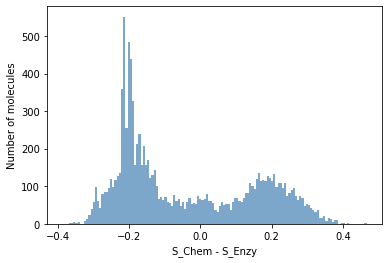

In [7]:
draw_sfscore_difference_distribution(in_vitro_sfscore[in_vitro_not_in_train_idxs],"Benchmark on in_vitro dataset")

In [10]:
get_diff_margin_distribution(in_vitro_sfscore[in_vitro_not_in_train_idxs])

margin: 0.05, chem_search_precent: 34.7632%, enzy_search_precent: 56.4937%, overlap_search_precent: 8.7431%
margin: 0.1, chem_search_precent: 30.9098%, enzy_search_precent: 52.0767%, overlap_search_precent: 17.0135%


margin: 0.15, chem_search_precent: 25.0023%, enzy_search_precent: 44.0244%, overlap_search_precent: 30.9734%
margin: 0.2, chem_search_precent: 16.3683%, enzy_search_precent: 25.2113%, overlap_search_precent: 58.4204%
margin: 0.25, chem_search_precent: 8.5340%, enzy_search_precent: 7.0163%, overlap_search_precent: 84.4497%


# One-step retrosynthesis search
Cost around 43.5 hours

In [8]:
import json
from tqdm import tqdm

search_tool_path = project_directory/'pathway_search_standalone'
sys.path.append(str(search_tool_path))

from scripts.search_utils import hybridSearch

hybridSearch = hybridSearch()
hybridSearch.unit_test()


project_directory:  /home/xuan/GitLab/synthetic-field-score
INFO@pricer              : [1689046919.814s]	Loaded prices from flat file
INFO@retro_transformer   : [1689046919.815s]	Loading template prioritizer for RetroTransformer
INFO@retro_transformer   : [1689046921.982s]	Loading precursor prioritizer for RetroTransformer
INFO@pricer              : [1689046923.000s]	Cannot connect to mongodb to load prices
INFO@pricer              : [1689046923.520s]	Loaded prices from flat file
INFO@retro_transformer   : [1689046923.557s]	Loading fast filter for RetroTransformer
INFO@fast_filter         : [1689046923.558s]	Starting to load fast filter
INFO@fast_filter         : [1689046924.264s]	Done loading fast filter
INFO@retro_transformer   : [1689046924.266s]	Using default clustering for RetroTransformer
INFO@retro_transformer   : [1689046924.267s]	Loading retro-synthetic transformer
INFO@retro_transformer   : [1689046924.267s]	reading from file
INFO@template_transformer: [1689046924.267s]	Loadi

/opt/conda/conda-bld/pytorch_1591914834915/work/aten/src/ATen/native/BinaryOps.cpp:66: UserWarning: Integer division of tensors using div or / is deprecated, and in a future release div will perform true division as in Python 3. Use true_divide or floor_divide (// in Python) instead.


Checking RXN4Chemistry retro model...Done
Checking ASKCOS(Enzy) model...Done
Done unit test.


In [9]:
class NumpyFloatValuesEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.float32):
            return float(obj)
        return JSONEncoder.default(self, obj)

In [10]:
i = 0

with tqdm(zip(in_vitro_not_in_train_idxs, in_vitro_sfscore, in_vitro_subset),total=len(in_vitro_subset)) as tcal:
    for idx,sfscore,smiles in tcal:
        if idx:
            tcal.set_description(f"Working on {i}")

            in_vitro_search_result={}
            in_vitro_search_result['smiles'] = smiles
            in_vitro_search_result['sfscore'] = sfscore.tolist()

            # Search chemical reaction
            # print(f'Working on {i}, SFScore={sfscore.tolist()}, smiles={smiles}')
            chem_result_list = hybridSearch.get_rxn4chem_result(smiles,fap=0)
            in_vitro_search_result['chem_result'] = chem_result_list
            chem_bw_confidence_list = []
            for chem_rxn in chem_result_list:
                chem_bw_confidence_list.append(chem_rxn['bw_confidence'])
            in_vitro_search_result['chem_bw_confidence_list'] = chem_bw_confidence_list
            
            # Search enzymatic reaction
            enzy_precursors = hybridSearch.askcos_enzy.get_outcomes(smiles,fast_filter_threshold=0, max_num_templates=250, 
                                                    max_cum_prob=0.9999, cluster_precursors=False, use_ban_list=False,
                                                    )
            enzy_precursors = enzy_precursors[:15]
            enzy_template_score_list = []
            for enzy_rxn in enzy_precursors:
                enzy_template_score_list.append(enzy_rxn['template_score'])
            in_vitro_search_result['enzy_template_score_list'] = enzy_template_score_list
            in_vitro_search_result['enzy_result'] = enzy_precursors

            tcal.set_postfix(smiles=smiles, sfscore=sfscore.tolist(),chem_result_list=len(chem_result_list), enzy_precursors=len(enzy_precursors))

            with open(f"../data/in_vitro_search_result/in_vitro_{i}.json", "w") as outfile:
                json.dump(in_vitro_search_result, outfile, cls=NumpyFloatValuesEncoder)
            
            i+=1


Working on 11002: 100%|██████████| 12000/12000 [43:34:39<00:00, 13.07s/it, chem_result_list=7, enzy_precursors=15, sfscore=[0.582015335559845, 0.4182663559913635], smiles=COc1cccc(C2(C(F)(F)F)NN2)c1]                                                                                                                                                                                                                          
